# Decision Tree Algorithms

這次我要練習的是Decision Tree algoritms，我們這邊會試著應用的是 basic Classification and Regression Tree(C&RT) Algorithms：


Func. Decision Tree (data D = $\{x_{n},y_{n}\}_{n=1}^{N}$) :

If termination criteria met :

  
  ###  return $g_{t}(x)$
 
else : 

  ### split D to 2 parts $D_{2} = \{(x_{n},y_{n}): b(x_{n})=c\}$
  
### b(x) = $argmin_{h(x)} \Sigma_{c=1}^{2}|D_{c} with \  h|*impurity(D_{c} with \  h)$


### Impurity function : Gini index 

$$1 - \Sigma_{k=1}^{K}(\frac{ \Sigma_{n=1}^{N} \ \ [y_{n} =k]}{N})$$

Termination Criteria :

* all $y_{n}$ the same : impurity = 0 $\rightarrow g_{t}(x) = y_{n}$

* all $x_{n}$ the same : no decisiont stumps.

因為我們每次在砍樹的時候都將data set 一分為二，所以是一個Binary Decision Tree。每一次在選擇要砍哪裡的時候，我們都選擇impurity最低的點，這樣讓砍完之後的樹枝的純度都會最高。如果砍到最後所有的$y_{n}$都一樣，我們就會停止再往下砍，並且讓$g_{t} = y_{n}$，如果所有的$X_{n}$都相同，那我們也會因為沒有下刀的地方而停止往下砍。

In [1]:
import numpy as np
import sys
from matplotlib import pyplot as plt

X_train = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw3_dectree_train.dat.txt")
X_test = np.genfromtxt("/Users/huangyuchen/Desktop/ML_NTU/hw3_dectree_test.dat.txt")
X = X_train[:,:2]
y = X_train[:,2]
X_te = X_test[:,:2]
y_te = X_test[:,2]

X_train.shape,X_test.shape

((100, 3), (1000, 3))

### 先偷看一下data。

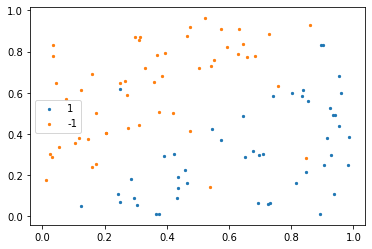

In [2]:
plt.scatter(X_train[X_train[:,-1] == 1][:, 0], X_train[X_train[:,-1] == 1][:, 1], s = 5, label='1')
plt.scatter(X_train[X_train[:,-1] ==-1][:, 0], X_train[X_train[:,-1] ==-1][:, 1], s = 5, label='-1')
plt.legend(['1','-1'])

我們先將Gini index算出來，因為在選擇branch的時候需要用到impurity func.，而impurity func.會用到Gini index，當然也有其他的方式可以當作impurity 的權重，例如回歸誤差或是分類誤差等等。

In [3]:
def ginindex(y):
    ## 如果不純度=0
    if len(y) == 0:
        return 0
    ## y只有1&-1兩種
    else:
        gin = 1-(1/(len(y)**2))*((np.sum([y==1]))**2+(np.sum([y==-1]))**2)
        return gin
    
def impurity(y1,y2):
    ## 因為下刀之後是一分為二，所以兩個區塊的impurity都要計算，同時也要將不同區塊的大小納入考慮
        return len(y1)*ginindex(y1)+len(y2)*ginindex(y2)

因為我們這裡砍樹的方式是使用Decision stump，所以一樣要產生一組 Theta，方法跟我們做desicion stump的時候一樣。

In [4]:
def genertheta(x):
    TrainX = sorted(x)
    Second = np.append(TrainX[1:],(TrainX[-1]))
    Theta = np.insert((TrainX+Second)/2,0,TrainX[0]-0.1,0)
    Theta[-1] = TrainX[-1] + 0.1
    return Theta

In [5]:
def decision_stump(X,y):
    m,n = X.shape
    imp = sys.maxsize
    t = 0 
    D = 0
    ## scan through every dimension of X
    for i in range(n):
        theta = genertheta(X[:,i])
        ## scan through every possible point of Theta
        for thet in theta:
            y1 = y[X[:,i]< thet]
            y2 = y[X[:,i]>= thet]
            ## update when smaller Ginin index appears.
            if impurity(y1,y2) < imp:
                imp = impurity(y1,y2)
                D = i
                t = thet
    ## return theta,dimension,and Gini index w/ smallest Gini index  
    return t,D,imp

定義一個Binary tree讓我們可以儲存每一個branch。

In [6]:
class Tree:
    def __init__(self, theta,D,value = None):
        self.theta = theta
        self.D = D
        ## 因為只有最後一層會需要儲存value，所以預設是None
        self.value = value
        self.left = None
        self.right = None

還要判斷何時要停止向下砍樹，也就是 X 和 y 都相同的時候。

In [7]:
def stop(X,y):
    n1 = np.sum(X!=X[0])
    n2 = np.sum(y!=y[0])
    return n1 == 0 or n2 == 0

接下來我們開始砍樹，如果 terminal condition met，我們就回傳最後一個 Tree Node，裡面只有紀錄 Tree.value，也就是我們的 $g_{t}$，else: 將 X 一分為二，小於Theta 的就存到左樹，大於的到右樹，並在節點紀錄 Theta 和 D，方便我們在查詢時知道 x 應該要往哪裡跑。

In [8]:
def growntree(X,y):
    if stop(X,y):
        return Tree(None,None,y[0])
    else:
        theta,D,imp = decision_stump(X,y)
        #print(theta,D,imp)
        X1 = X[X[:,D]<theta]
        y1 = y[X[:,D]<theta]
        X2 = X[X[:,D]>=theta]
        y2 = y[X[:,D]>=theta]
        tree = Tree(theta,D)
        tree.left = growntree(X1,y1)
        tree.right = growntree(X2,y2)
        return tree

我們使用 growntree 長完整棵樹之後，會儲存所有的節點，由節點可以幫助我們判斷 x 應該要怎麼走，接著我們在定義一個 scan func.來讓所有 x scan through 所有的節點，來幫助我們得到 x 預測的值。這邊一樣用 recursion 來完成。

In [9]:
def scan(tree, x):
    if tree.value != None:
        return tree.value
    if x[tree.D] < tree.theta:
        return scan(tree.left,x)
    else:
        return scan(tree.right,x)

把所有的 x 都丟進去一個個找出他對應的 $g_{t}$。

In [10]:
def error(tree, X, y):
    ypred = [scan(tree, x) for x in X]
    return np.mean(ypred!=y)

In [11]:
tree = growntree(X,y)
print("Ein = ",error(tree,X,y))

Ein =  0.0


In [12]:
print("Eout =",error(tree,X_te,y_te))

Eout = 0.126


Decision Tree 有一個問題，就是不管怎麼樣，一定可以完全砍完(最差就是一個點一個分支)，想當然就會有很大的 overfitting 的問題，我們如果要解決這個問題，砍樹是其中一個選擇，限制 Decision Tree 分支的數量，容忍一定程度的誤差，就可以有效的限制 overfitting 產生。